In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ks_2samp

# Load and Inspect Dataset

In [41]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [45]:
# Check the uniquess of data
df['userid'].nunique() == df.shape[0]

True

In [46]:
# Check the missing value
df.isnull().sum() == 0

userid            True
version           True
sum_gamerounds    True
retention_1       True
retention_7       True
dtype: bool

In [55]:
# Check the summary statistics
df.describe([0.05, 0.25, 0.50, 0.75])[["sum_gamerounds"]]

,sum_gamerounds
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
5%,1.000000
25%,5.000000
50%,16.000000
75%,51.000000
max,49854.000000


In [58]:
# Check the statistic between A and B group 
df.groupby('version')['sum_gamerounds'].agg(['count','mean','median','std','min','max'])

,count,mean,median,std,min,max
version,,,,,,
gate_30,44700,52.456264,17,256.716423,0,49854
gate_40,45489,51.298776,16,103.294416,0,2640


<AxesSubplot:xlabel='version', ylabel='sum_gamerounds'>

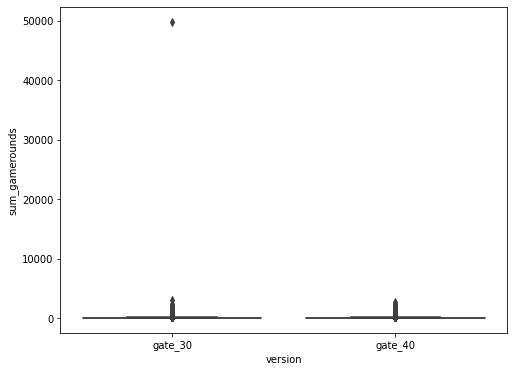

In [64]:
# Boxplot indicate the outlier
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x = df['version'], y = df['sum_gamerounds'], ax = ax)

<b>Takeaway:</b> The dataset is missing value free, but there is a outlier in the number of game played by group gate_30 (A)

# Analyzing Player Behavior

In [77]:
# Check the number of the gameplay distribution
df_count = pd.DataFrame(df.groupby('sum_gamerounds')['userid'].count())
df_count.rename(columns={'userid': 'Count'}, inplace=True)
df_count

,Count
sum_gamerounds,
0,3994
1,5538
2,4606
3,3958
4,3629
...,...
2294,1
2438,1
2640,1


<AxesSubplot:title={'center':'Number of players that played 0 to 100 games during the first week'}, xlabel='sum_gamerounds'>

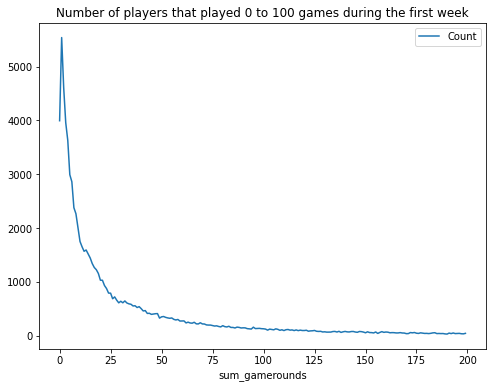

In [80]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Number of players that played 0 to 100 games during the first week')
sns.lineplot(data = df_count[:200], ax = ax)

Based on above results, <b>nearly 4000 users nevery played the game and 50% of players played fewer than 16 game rounds</b>, possible reasons could be:
* They have no free time for games
* They don't like the icon or interface of the game
* They are distracted by similar alternatives
* They get bored of the game very soon

<b>The number of players sigficantly decrease as the levels progress:</b>
* The instruction or tutor of game might be vague
* The difficulty of the game might be imbalanced
* The reward of higher levels could be more intriguing

In [81]:
# remove outlier
df = df[df['sum_gamerounds'] < df['sum_gamerounds'].max()]

Now let's dive deeper to see whether two rentention variables are statistically significant between group A (gate_30) and B (gate_40).
* retention_1: did the player come back and play one day after installing?
* retention_7: did the player come back and play seven days after installing?

In this scenerio, player will only experience the difference between gate_30 and gate_40 once they encounter it. Therefore, to accurately evaluate the gate system, it is ideally to drop the users who has not played more than 30 rounds in both control and treatment groups.  

In [ ]:
# Drop users played fewer than 30
df_30 = df.copy()
df_30 = df_30[df_30['sum_gamerounds'] >= 30]

In [113]:
df_1_30 = pd.DataFrame(df_30.groupby('version')[['retention_1']].mean())
df_7_30 = pd.DataFrame(df_30.groupby('version')[['retention_7']].mean())
df_retention = df_1_30.merge(df_7_30, how='left', on='version')
df_retention

,retention_1,retention_7
version,,
gate_30,0.801021,0.438727
gate_40,0.801842,0.430025


* Around 55 percent of users stoped playing the game after day 1, around 80 percent of users stoped playing after day 7
* The retention rate after day 1 and 7 show slightly difference btween gate_30 and gate_40, but are those difference statistic significant? We will exame them through hypothesis testing (A/B testing)

# A/B Testing

In [114]:
# Split two dataframes based on version, control: gate_30, treatment: gate_40
df_control = df_30[df_30['version'] == 'gate_30']
df_treat = df_30[df_30['version'] == 'gate_40']

In [115]:
# Check the size of control and treatment group
print('The size of control group is {}'.format(df_control.shape[0]))
print('The size of treatment group is {}'.format(df_treat.shape[0]))

The size of control group is 16655
The size of treatment group is 16613


Version 'gate_40' increase the average play rounds

In [117]:
df_30.groupby('version')[['sum_gamerounds']].mean()

,sum_gamerounds
version,
gate_30,122.092645
gate_40,124.466502


<b>Evaluate the retention rate</b>

In [118]:
# Bootstrapped for retention_1
boot_1d = []
for i in range(1000):
    boot_mean = df_30.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)

Text(0.5, 0.98, 'Retention rate after day 1')

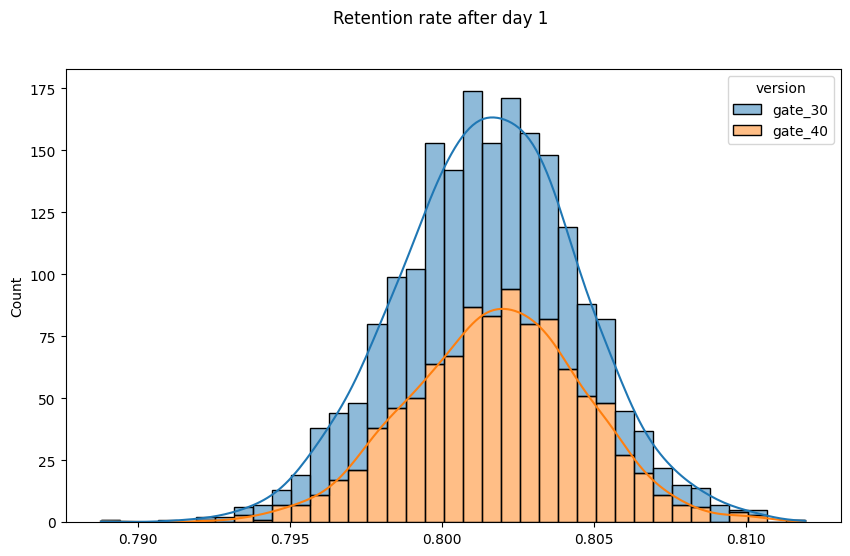

In [136]:
plt.figure(figsize=(10,6), dpi = 100)
sns.histplot(data = boot_1d, kde=True, multiple='stack')
plt.suptitle('Retention rate after day 1')

Text(0.5, 0.98, 'Retention rate after day 7')

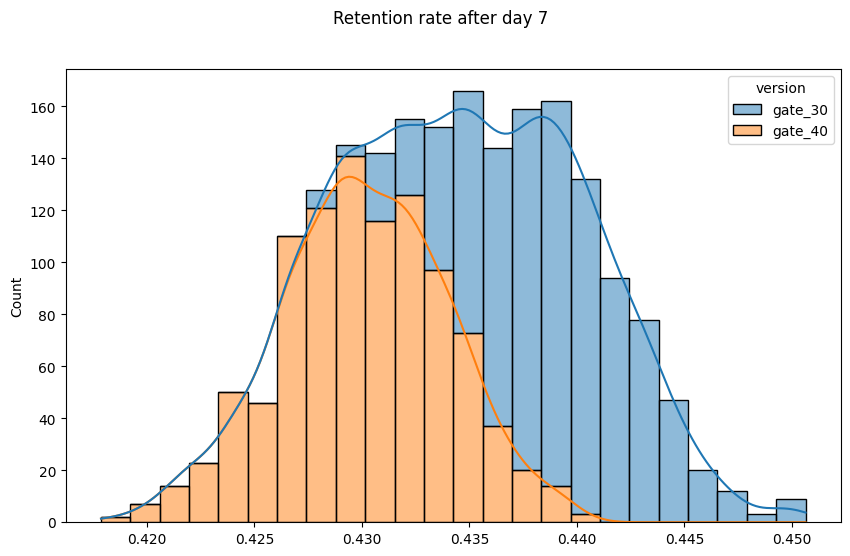

In [137]:
# Bootstrapped for day 7
boot_7d = []
for i in range(1000):
    boot_mean = df_30.sample(frac = 1,replace = True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Visualization
plt.figure(figsize=(10,6), dpi = 100)
sns.histplot(data = boot_7d, kde=True, multiple='stack')
plt.suptitle('Retention rate after day 7')

<b>Takeaway</b>: We can see the retention rate is nearly indistinguishable between gate_30 and gate_40 after day 1, but shows more significant difference after day 7.

<b>Normality Assumption</b>

* H0: Normal distribution assumption is provided
* H1: Normal distribution assumption is not provided

Significance level: 0.05

In [159]:
_,p_value_c = shapiro(df_control['sum_gamerounds'])
_,p_value_t = shapiro(df_treat['sum_gamerounds'])
print('p value for control group: {}'.format(round(p_value_c,2)))
print('p value for treatment group: {}'.format(round(p_value_t,2)))

p value for control group: 0.0
p value for treatment group: 0.0


Text(0.5, 1.0, 'Gate_40')

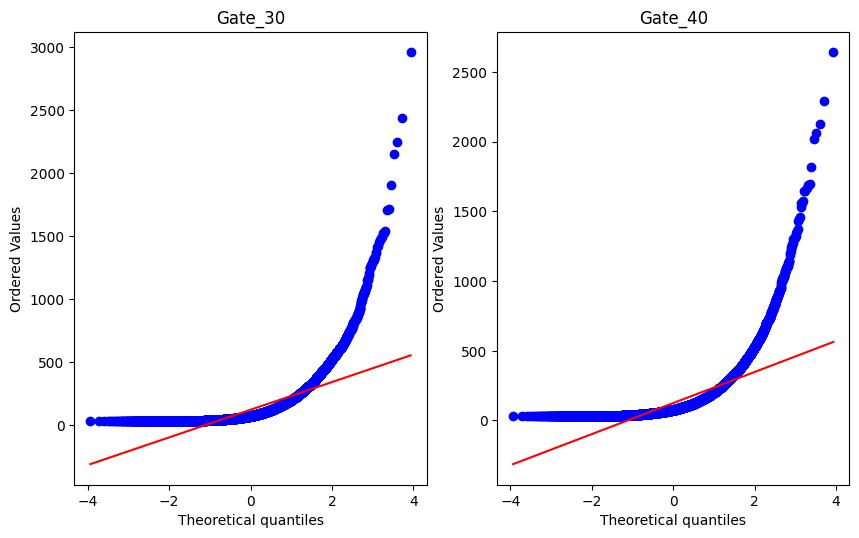

In [165]:
# Q-Q plot
fig = plt.figure(figsize=(10,6), dpi = 100)
ax1 = plt.subplot(121)
stats.probplot(df_control['sum_gamerounds'],plot=sns.mpl.pyplot)
ax1.set_title('Gate_30')
ax2 = plt.subplot(122)
stats.probplot(df_treat['sum_gamerounds'],plot=sns.mpl.pyplot)
ax2.set_title('Gate_40')

<b>Comment:</b> We can reject H0 since the p value equal to 0 < 0.05, the Q-Q plot also agrees with the observation, two samples are not normally distributed.

<b>Variance Homogeneity Assumption (Levene Testi)</b>

* H0: Variances are homogeneous
* H1: Variances are not homogenerous

Significance level: 0.05

In [166]:
stats.levene(df_control['sum_gamerounds'], df_treat['sum_gamerounds'])

LeveneResult(statistic=0.1049301583062975, pvalue=0.7459936359136907)

<b>Comment:</b> Since the p value = 0.75 > 0.05, we can not reject the H0 hypothesis, so the variances are homogeneous between these two distributions

<b>Kolmogorov-Smirnov (K-S) test</b>

* H0: Control and treatment group are not difference in terms of sum_gamerounds
* H1: Control and treatment group are difference in terms of sum_gamerounds

Significance level: 0.05

In [171]:
ktest_score, p_value = ks_2samp(df_control['sum_gamerounds'], df_treat['sum_gamerounds'])

In [172]:
p_value

6.491360679805536e-09

<b>Takeaway</b>:<br> Giving the p value (6.5e-09) of K-S test < significance level alpha (0.05), we can conclude that the sum_gamerounds are statistically significantly different between gate_30 and gate_40

# Conclusion

The bootstrap shows that 7-day retention is higher when the gate is set at level 30 than when it is at level 40, but the difference is barely distinguiable for 1-day retention rate. 

Generally, the gate system does not affect 1-day retention rate whether it is gate_30 or gate_40, since the majority of players are unlikely to play more than 30 rounds in one day. As for 7-day retention rate, the difference between gate_30 and gate_40 are statistically significant, we suggest to keep the gate at level 30 instead of level 40, since it will keep a higher retention rate. 